In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier ,GradientBoostingRegressor

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

c:\python3.5.1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#加载几行看看
pd.set_option('display.max_columns',None)
full=pd.read_table('./ctrip/competition_train.txt',header=0,nrows=10)
#full[['star','uid','price_deduct','user_ordernum','user_avgroomarea','user_activation','user_avgstar','user_avgprice_star','user_avgpromotion','user_avgdealprice','orderlabel']]
full.head()

,orderid,uid,orderdate,hotelid,basicroomid,roomid,orderlabel,star,rank,returnvalue,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_2,roomservice_3,roomservice_4,roomservice_5,roomservice_6,roomservice_7,roomservice_8,roomtag_1,roomtag_2,roomtag_3,roomtag_4,roomtag_5,roomtag_6,user_confirmtime,user_avgadvanceddate,user_avgstar,user_avggoldstar,user_avgrecommendlevel,user_avgroomnum,ordertype_1_ratio,ordertype_2_ratio,ordertype_3_ratio,ordertype_4_ratio,ordertype_5_ratio,ordertype_6_ratio,ordertype_7_ratio,ordertype_8_ratio,ordertype_9_ratio,ordertype_10_ratio,ordertype_11_ratio,user_avgdealpriceholiday,user_avgdealpriceworkday,user_avgdealprice,user_avgpromotion,user_avgprice_star,orderbehavior_1_ratio,orderbehavior_2_ratio,orderbehavior_3_ratio_1week,orderbehavior_4_ratio_1week,orderbehavior_5_ratio_1week,orderbehavior_3_ratio_1month,orderbehavior_4_ratio_1month,orderbehavior_5_ratio_1month,orderbehavior_3_ratio_3month,orderbehavior_4_ratio_3month,orderbehavior_5_ratio_3month,orderbehavior_6_ratio,orderbehavior_7_ratio,orderbehavior_8,orderbehavior_9,user_ordernum,user_activation,user_avgprice,user_maxprice,user_minprice,user_stdprice,user_cvprice,user_citynum,user_avgroomarea,user_roomservice_4_0ratio,user_roomservice_4_2ratio,user_roomservice_4_3ratio,user_roomservice_4_4ratio,user_roomservice_4_1ratio,user_roomservice_4_5ratio,user_roomservice_3_123ratio,user_roomservice_6_2ratio,user_roomservice_6_1ratio,user_roomservice_6_0ratio,user_roomservice_5_1ratio,user_roomservice_7_0ratio,user_roomservice_2_1ratio,user_roomservice_8_1ratio,user_rank_ratio,user_roomservice_5_345ratio,user_ordnum_1week,user_avgprice_1week,user_medprice_1week,user_minprice_1week,user_maxprice_1week,user_roomservice_3_123ratio_1week,user_roomservice_7_1ratio_1week,user_roomservice_7_0ratio_1week,user_roomservice_4_5ratio_1week,user_roomservice_4_4ratio_1week,user_roomservice_4_2ratio_1week,user_roomservice_4_3ratio_1week,user_roomservice_4_0ratio_1week,user_ordnum_1month,user_avgprice_1month,user_medprice_1month,user_minprice_1month,user_maxprice_1month,user_roomservice_3_123ratio_1month,user_roomservice_7_1ratio_1month,user_roomservice_7_0ratio_1month,user_roomservice_4_5ratio_1month,user_roomservice_4_4ratio_1month,user_roomservice_4_2ratio_1month,user_roomservice_4_3ratio_1month,user_roomservice_4_0ratio_1month,user_ordnum_3month,user_avgprice_3month,user_medprice_3month,user_minprice_3month,user_maxprice_3month,user_roomservice_3_123ratio_3month,user_roomservice_7_1ratio_3month,user_roomservice_7_0ratio_3month,user_roomservice_4_5ratio_3month,user_roomservice_4_4ratio_3month,user_roomservice_4_2ratio_3month,user_roomservice_4_3ratio_3month,user_roomservice_4_0ratio_3month,basic_week_ordernum_ratio,basic_recent3_ordernum_ratio,basic_comment_ratio,basic_30days_ordnumratio,basic_30days_realratio,room_30days_ordnumratio,room_30days_realratio,orderid_lastord,orderdate_lastord,hotelid_lastord,roomid_lastord,basicroomid_lastord,rank_lastord,return_lastord,price_last_lastord,roomservice_2_lastord,roomservice_3_lastord,roomservice_4_lastord,roomservice_5_lastord,roomservice_6_lastord,roomservice_8_lastord,roomtag_2_lastord,roomtag_3_lastord,roomtag_4_lastord,roomtag_5_lastord,roomtag_6_lastord,star_lastord,hotel_minprice_lastord,basic_minprice_lastord
0,ORDER_12251191,USER_318560,2013-04-15,HOTEL_174550,BASIC_635351,ROOM_27728713,0,9,3,200.0,3830.0,NaN,NaN,NaN,0,0,2,0,0,0,1,0,NaN,490.0,0,0,0,-991.82355,1.470588,7.235294,6.647059,11.705882,302.0,0.25,0.058824,0.0,0.0,0.0,0.294118,0.705882,0.941176,0.352941,0.294118,0.0,1657.3999,932.8,1113.95,237.35,1188.9412,0.0,0.235294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.230769,0.307692,34.88,68.36923,334,4.475698,1113.95,2750.0,440.0,NaN,NaN,212.0,1.0,NaN,0.823529,0.235294,0.823529,NaN,NaN,0.294118,NaN,NaN,NaN,0.352941,0.411765,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [9]:
#columns=['star','rank','orderdate','hotelid','basicroomid','returnvalue','price_deduct','basic_minarea','basic_maxarea']
#full_cols=['orderid','orderdate','hotelid','basicroomid','roomid','star','rank','returnvalue','price_deduct','basic_minarea','basic_maxarea','orderlabel']
full_cols=['orderid','roomid','orderlabel']
#加入部分用户特征
#是否可以根据用户特征，以及用户喜好，以及用户上次订单的状况对用户对房型、星级等信息评价出等级。
#
#full_cols.extend(['uid','user_ordernum','user_avgroomarea','user_activation','user_avgstar','user_avgprice_star','user_avgpromotion','user_avgdealprice'])
#full_cols.extend(['uid','user_ordernum','user_avgroomarea','user_activation','user_avgstar','user_avgprice_star','user_avgpromotion','user_avgdealprice'])
full_cols.extend(['star', 'rank', 'price_deduct', 'basic_minarea', \
       'basic_maxarea', 'roomservice_1', 'roomservice_3', 'roomservice_4', \
       'roomservice_6', 'roomservice_7', 'roomservice_8', 'roomtag_1', \
       'roomtag_2', 'roomtag_3', 'roomtag_4', 'user_avgstar', \
       'user_avgdealpriceworkday', 'user_avgprice_star', 'orderbehavior_9', \
       'user_maxprice', 'basic_week_ordernum_ratio', \
       'basic_recent3_ordernum_ratio', 'basic_comment_ratio', \
       'basic_30days_ordnumratio', 'basic_30days_realratio', \
       'room_30days_ordnumratio', 'room_30days_realratio'])

#columns.extend(['uid','user_ordernum','user_avgroomarea','user_activation','user_avgstar','user_avgprice_star','user_avgpromotion','user_avgdealprice'])
#for i in range(1,9):
#    full_cols.append('roomservice_'+str(i))
#    #columns.append('roomservice_'+str(i))
#for i in range(1,7):
#    full_cols.append('roomtag_'+str(i))
#    #columns.append('roomtag_'+str(i))
print(len(full_cols))

30


In [10]:
#加载所有训练集数据
chunks=pd.read_table('./ctrip/competition_train.txt',header=0,#nrows=50000
                    chunksize=10**5,
                    usecols=full_cols
                   )
full_train=pd.DataFrame()
%time full_train=pd.concat(chunk for chunk in chunks)

CPU times: user 1min 2s, sys: 5.71 s, total: 1min 8s
Wall time: 1min 9s


Wall time: 2min 40s

In [ ]:
#加载部分数据，所有列都加载
#%time full_train=pd.read_table('D:\GitHub\Kesci\ctrip\competition_train.txt',header=0,nrows=50000)

In [11]:
pd.set_option('display.max_columns',None)
#看看数据集情况
print(full_train.shape)
#full_train.describe()
#有些列都是空的

(7724875, 30)


In [6]:
#对于缺失的数据，删除全部都是空的列，并用平均值进行填充
#如果不用整体均值填充，是否可以通过按用户、房型区分均值进行填充df[['value']].fillna(df.groupby('group').transform('mean'))
#对所有列进行空值填充速度非常慢
#full_train.dropna(axis =1,how='all').shape

In [ ]:
#basic_maxarea 这个字段有负数，需要进行处理--TODO
#full_train[(full_train.basic_minarea<0) | (full_train.basic_maxarea<0)]

In [12]:
#%time full_train.dropna(axis =1,how='all',inplace=True)
#用平均值填充速度非常慢，如果改成循环每列单独填充，是否会提高速度？
#full_train.fillna(full_train.mean(),inplace=True)
#%time full_train.fillna(0,inplace=True)
%time full_train.describe()


CPU times: user 14.1 s, sys: 5.35 s, total: 19.5 s
Wall time: 19.6 s


,orderlabel,star,rank,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_3,roomservice_4,roomservice_6,roomservice_7,roomservice_8,roomtag_1,roomtag_2,roomtag_3,roomtag_4,user_avgstar,user_avgdealpriceworkday,user_avgprice_star,orderbehavior_9,user_maxprice,basic_week_ordernum_ratio,basic_recent3_ordernum_ratio,basic_comment_ratio,basic_30days_ordnumratio,basic_30days_realratio,room_30days_ordnumratio,room_30days_realratio
count,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,6.855372e+06,6.855372e+06,6.855372e+06,7.724875e+06,7.708065e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,2.222360e+06,6.792069e+06,7.724875e+06,7.724875e+06,7.172420e+06,7.699523e+06,7.670714e+06,7.724875e+06,7.549721e+06,7.549721e+06,7.549721e+06,4.397222e+06,4.397222e+06,4.397222e+06,4.397222e+06
mean,2.738944e-02,8.843464e+00,1.156930e+01,2.893330e+03,8.692999e+01,8.914625e+01,1.932033e+00,1.013409e+00,2.708873e+00,5.231453e-01,3.262490e-01,2.357811e+00,2.623123e-02,3.086659e+02,4.873833e+02,1.894402e-01,8.256404e+00,1.699672e+03,1.769836e+03,9.386414e+01,4.124189e+03,1.906616e-01,1.887479e-01,1.820961e-01,2.357308e-01,1.267148e+00,5.945367e-02,1.348485e+00
std,1.632154e-01,2.167494e+00,1.124343e+01,6.910387e+03,8.960929e+01,9.037341e+01,3.205340e-01,9.772677e-01,9.564277e-01,8.268800e-01,4.688397e-01,1.436833e+00,1.598223e-01,5.382480e+00,1.877064e+01,3.918579e-01,1.876450e+00,1.089619e+03,1.162397e+03,5.032055e+01,4.494339e+03,2.449086e-01,2.520817e-01,2.201423e-01,2.390178e-01,5.090026e-01,9.780025e-02,5.526576e-01
min,0.000000e+00,5.000000e+00,3.000000e+00,2.300000e+02,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.020000e+02,3.600000e+02,0.000000e+00,1.000000e+00,2.030000e+02,2.030000e+02,2.800000e+00,2.030000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.778550e-04,1.000000e+00,2.185792e-04,1.000000e+00
25%,0.000000e+00,7.000000e+00,5.000000e+00,1.034000e+03,5.300000e+01,5.700000e+01,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.020000e+02,4.840000e+02,0.000000e+00,7.000000e+00,9.963561e+02,9.635790e+02,5.460000e+01,1.502000e+03,1.212121e-02,0.000000e+00,2.102804e-02,4.961832e-02,1.006917e+00,7.246377e-03,1.056605e+00
50%,0.000000e+00,9.000000e+00,9.000000e+00,1.673000e+03,7.100000e+01,7.300000e+01,2.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,3.100000e+02,4.960000e+02,0.000000e+00,8.612904e+00,1.427783e+03,1.442000e+03,8.260000e+01,2.804000e+03,8.108108e-02,7.246377e-02,9.004499e-02,1.481482e-01,1.114630e+00,2.272727e-02,1.190654e+00
75%,0.000000e+00,1.100000e+01,1.500000e+01,3.029000e+03,9.900000e+01,1.010000e+02,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,3.100000e+02,5.000000e+02,0.000000e+00,9.666667e+00,2.072750e+03,2.257367e+03,1.235500e+02,5.180000e+03,2.781457e-01,2.784810e-01,2.651448e-01,3.484848e-01,1.319025e+00,6.703911e-02,1.428115e+00
max,1.000000e+00,1.100000e+01,2.450000e+02,6.001970e+05,1.416100e+04,1.416100e+04,2.000000e+00,3.000000e+00,5.000000e+00,2.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,4.220000e+02,1.300000e+03,1.000000e+00,1.100000e+01,3.713660e+04,1.692800e+04,2.010000e+02,1.796930e+05,1.000000e+00,1.000000e+00,3.996904e+00,1.000000e+00,4.327850e+01,1.000000e+00,4.327850e+01


In [ ]:
#xLabels=[x for x in full_train.columns if x !='orderid' and x !='orderlabel' ]
#xLabels

In [14]:
full_train_y=full_train['orderlabel']

full_train_X=full_train.drop(labels=['orderid','roomid','orderlabel'],axis=1)
#full_train_X.basic_minarea.fillna(full_train_X.basic_minarea.mean(),inplace=True)
#full_train_X.basic_maxarea.fillna(full_train_X.basic_maxarea.mean(),inplace=True)
#%time full_train_X.fillna(0,inplace=True)
#使用平均值填充
for col in full_train_X.columns:
    %time full_train_X[col].fillna(full_train_X[col].mean(),inplace=True)
full_train_X.shape

CPU times: user 58 ms, sys: 56 ms, total: 114 ms
Wall time: 138 ms
CPU times: user 49.2 ms, sys: 56.8 ms, total: 106 ms
Wall time: 119 ms
CPU times: user 41.2 ms, sys: 10.7 ms, total: 51.9 ms
Wall time: 51.7 ms
CPU times: user 49.4 ms, sys: 13.9 ms, total: 63.3 ms
Wall time: 63.9 ms
CPU times: user 47.6 ms, sys: 11.2 ms, total: 58.8 ms
Wall time: 58.6 ms
CPU times: user 47.9 ms, sys: 10.8 ms, total: 58.7 ms
Wall time: 58.5 ms
CPU times: user 57.5 ms, sys: 68.3 ms, total: 126 ms
Wall time: 142 ms
CPU times: user 43.9 ms, sys: 11.1 ms, total: 55 ms
Wall time: 54.8 ms
CPU times: user 55 ms, sys: 67.1 ms, total: 122 ms
Wall time: 131 ms
CPU times: user 56.9 ms, sys: 71.7 ms, total: 129 ms
Wall time: 134 ms
CPU times: user 51.8 ms, sys: 26.2 ms, total: 78 ms
Wall time: 80.2 ms
CPU times: user 51.3 ms, sys: 10.4 ms, total: 61.7 ms
Wall time: 61.5 ms
CPU times: user 91.4 ms, sys: 13.6 ms, total: 105 ms
Wall time: 104 ms
CPU times: user 64.4 ms, sys: 12.1 ms, total: 76.6 ms
Wall time: 76.3 ms


(7724875, 27)

In [15]:
full_train_X.describe()

,star,rank,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_3,roomservice_4,roomservice_6,roomservice_7,roomservice_8,roomtag_1,roomtag_2,roomtag_3,roomtag_4,user_avgstar,user_avgdealpriceworkday,user_avgprice_star,orderbehavior_9,user_maxprice,basic_week_ordernum_ratio,basic_recent3_ordernum_ratio,basic_comment_ratio,basic_30days_ordnumratio,basic_30days_realratio,room_30days_ordnumratio,room_30days_realratio
count,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06,7.724875e+06
mean,8.843464e+00,1.156930e+01,2.893330e+03,8.692999e+01,8.914625e+01,1.932033e+00,1.013409e+00,2.708873e+00,5.231453e-01,3.262490e-01,2.357811e+00,2.623123e-02,3.086659e+02,4.873833e+02,1.894402e-01,8.256404e+00,1.699672e+03,1.769836e+03,9.386414e+01,4.124189e+03,1.906616e-01,1.887479e-01,1.820961e-01,2.357308e-01,1.267148e+00,5.945367e-02,1.348485e+00
std,2.167494e+00,1.124343e+01,6.910387e+03,8.441562e+01,8.513545e+01,3.019561e-01,9.772677e-01,9.553865e-01,8.268800e-01,4.688397e-01,1.436833e+00,1.598223e-01,2.886980e+00,1.760088e+01,3.918579e-01,1.876450e+00,1.049933e+03,1.160488e+03,5.014384e+01,4.494339e+03,2.421162e-01,2.492075e-01,2.176322e-01,1.803324e-01,3.840285e-01,7.378760e-02,4.169650e-01
min,5.000000e+00,3.000000e+00,2.300000e+02,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.020000e+02,3.600000e+02,0.000000e+00,1.000000e+00,2.030000e+02,2.030000e+02,2.800000e+00,2.030000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.778550e-04,1.000000e+00,2.185792e-04,1.000000e+00
25%,7.000000e+00,5.000000e+00,1.034000e+03,5.700000e+01,5.700000e+01,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.086659e+02,4.873833e+02,0.000000e+00,7.000000e+00,1.028884e+03,9.653750e+02,5.480000e+01,1.502000e+03,1.302083e-02,0.000000e+00,2.195263e-02,1.171171e-01,1.082940e+00,1.754386e-02,1.152672e+00
50%,9.000000e+00,9.000000e+00,1.673000e+03,7.700000e+01,8.100000e+01,2.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,3.086659e+02,4.940000e+02,0.000000e+00,8.612904e+00,1.506916e+03,1.446500e+03,8.299519e+01,2.804000e+03,8.639309e-02,7.777778e-02,9.528214e-02,2.357308e-01,1.267148e+00,5.945367e-02,1.348485e+00
75%,1.100000e+01,1.500000e+01,3.029000e+03,9.100000e+01,9.500000e+01,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,3.086659e+02,5.000000e+02,0.000000e+00,9.666667e+00,2.002850e+03,2.253050e+03,1.231568e+02,5.180000e+03,2.711864e-01,2.702703e-01,2.589852e-01,2.357308e-01,1.267148e+00,5.945367e-02,1.348485e+00
max,1.100000e+01,2.450000e+02,6.001970e+05,1.416100e+04,1.416100e+04,2.000000e+00,3.000000e+00,5.000000e+00,2.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,4.220000e+02,1.300000e+03,1.000000e+00,1.100000e+01,3.713660e+04,1.692800e+04,2.010000e+02,1.796930e+05,1.000000e+00,1.000000e+00,3.996904e+00,1.000000e+00,4.327850e+01,1.000000e+00,4.327850e+01


## 特征缩放

In [17]:
from sklearn.preprocessing import minmax_scale
full_train_X_s=minmax_scale(full_train_X)
full_train_X.head()

,star,rank,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_3,roomservice_4,roomservice_6,roomservice_7,roomservice_8,roomtag_1,roomtag_2,roomtag_3,roomtag_4,user_avgstar,user_avgdealpriceworkday,user_avgprice_star,orderbehavior_9,user_maxprice,basic_week_ordernum_ratio,basic_recent3_ordernum_ratio,basic_comment_ratio,basic_30days_ordnumratio,basic_30days_realratio,room_30days_ordnumratio,room_30days_realratio
0,9,3,3830.0,86.929994,89.146249,1.932033,0,2.0,0,0,1,0,308.665914,490.000000,0,7.235294,932.8,1188.9412,68.36923,2750.0,0.190662,0.188748,0.182096,0.235731,1.267148,0.059454,1.348485
1,5,11,842.0,41.000000,41.000000,2.000000,0,5.0,0,0,2,0,310.000000,487.383332,0,9.000000,1325.0,1325.0000,76.00000,1343.0,0.366667,0.400000,0.168385,0.235731,1.267148,0.059454,1.348485
2,5,5,995.0,71.000000,71.000000,2.000000,0,2.0,2,1,2,0,310.000000,466.000000,0,9.000000,1325.0,1325.0000,76.00000,1343.0,0.000000,0.000000,0.008591,0.235731,1.267148,0.059454,1.348485
3,5,3,995.0,71.000000,71.000000,2.000000,0,2.0,2,1,2,0,310.000000,496.000000,0,9.000000,1325.0,1325.0000,76.00000,1343.0,0.000000,0.000000,0.008591,0.235731,1.267148,0.059454,1.348485
4,5,5,677.0,41.000000,41.000000,2.000000,0,5.0,0,0,1,0,308.665914,496.000000,0,9.000000,1325.0,1325.0000,76.00000,1343.0,0.366667,0.400000,0.168385,0.327273,1.000000,0.272727,1.000000


In [18]:
full_train_X_s[1:10]

array([[  0.00000000e+00,   3.30578512e-02,   1.02005610e-03,
          2.96568281e-03,   2.96568281e-03,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.50000000e-01,   0.00000000e+00,
          6.66666667e-02,   1.35514183e-01,   0.00000000e+00,
          8.00000000e-01,   3.03788420e-02,   6.70852018e-02,
          3.69323915e-01,   6.35132876e-03,   3.66666670e-01,
          4.00000000e-01,   4.21288267e-02,   2.35518410e-01,
          6.31876178e-03,   5.92480404e-02,   8.24261348e-03],
       [  0.00000000e+00,   8.26446281e-03,   1.27507013e-03,
          5.08402768e-03,   5.08402768e-03,   1.00000000e+00,
          0.00000000e+00,   4.00000000e-01,   1.00000000e+00,
          1.00000000e+00,   2.50000000e-01,   0.00000000e+00,
          6.66666667e-02,   1.12765957e-01,   0.00000000e+00,
          8.00000000e-01,   3.03788420e-02,   6.70852018e-02,
          3.69323915e-01,   6.35132876e-03,   0.00000000e+00,
       

## 标准化 (Standardization)
``le = preprocessing.LabelEncoder()``

获取训练集和测试集所有下面几列数据

fit所有数据

``le.fit(["tokyo", "tokyo", "paris","AAA","BBB"])``

分别转换训练集和测试集数据

``le.transform(["tokyo", "tokyo", "paris","BBB"])``

``le.transform(["tokyo", "tokyo", "paris","AAA"])``

In [8]:
from sklearn import preprocessing
le_uid = preprocessing.LabelEncoder()
le_orderdate = preprocessing.LabelEncoder()
le_hotelid = preprocessing.LabelEncoder()
le_basicroomid = preprocessing.LabelEncoder()
le_roomid = preprocessing.LabelEncoder()


%time temp_test_cols=pd.read_table('./ctrip/competition_test.txt',header=0, \
                              usecols=['uid','hotelid','orderdate','basicroomid','roomid'])
%time temp_train_cols=pd.read_table('./ctrip/competition_train.txt',header=0, \
                              usecols=['uid','hotelid','orderdate','basicroomid','roomid'])
#temp_train_cols =
temp_cols = pd.concat([temp_test_cols,temp_train_cols],ignore_index=True)

le_uid.fit(temp_cols['uid'])
le_orderdate.fit(temp_cols['orderdate'])
le_hotelid.fit(temp_cols['hotelid'])
le_basicroomid.fit(temp_cols['basicroomid'])
#le_roomid.fit(temp_cols['roomid'])


CPU times: user 45.2 s, sys: 3.47 s, total: 48.7 s
Wall time: 49.5 s
CPU times: user 47.3 s, sys: 3.86 s, total: 51.1 s
Wall time: 51.9 s


LabelEncoder()

In [264]:
a1=list(temp_cols['orderdate'].unique())
a1.sort()
a1

['2013-04-14',
 '2013-04-15',
 '2013-04-16',
 '2013-04-17',
 '2013-04-18',
 '2013-04-19',
 '2013-04-20',
 '2013-04-21',
 '2013-04-22',
 '2013-04-23',
 '2013-04-24',
 '2013-04-25',
 '2013-04-26',
 '2013-04-27']

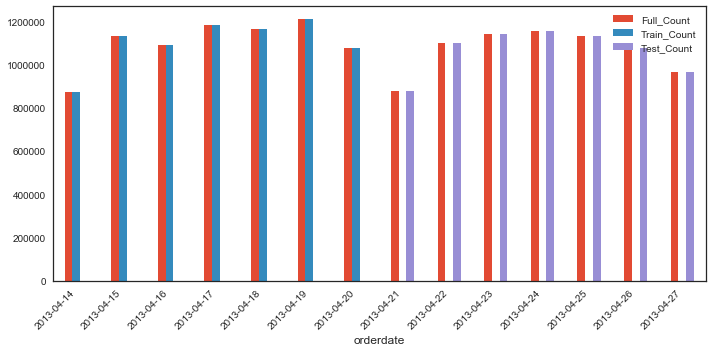

In [280]:
plt.figure(figsize=(10,5))
ax1=plt.subplot(1,1,1)
date_count=pd.DataFrame({'orderdate':a1})
date_count.set_index(['orderdate'],inplace=True)
date_count['Full_Count']=temp_cols.groupby(by=['orderdate'])['roomid'].count()
date_count['Train_Count']=temp_train_cols.groupby(by=['orderdate'])['roomid'].count()
date_count['Test_Count']=temp_test_cols.groupby(by=['orderdate'])['roomid'].count()
date_count.plot.bar(ax=ax1)
ax1.set_xticklabels(labels=date_count.index,rotation=45,ha='right');
plt.tight_layout()

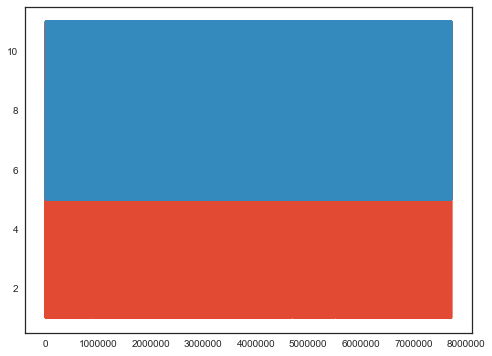

In [290]:
plt.figure()
plt.plot(full_train[['user_avgstar','star']],)

In [16]:
#%time full_train_X['uid']=le_uid.transform(full_train['uid'])
%time full_train_X['orderdate']=le_orderdate.transform(full_train['orderdate'])
%time full_train_X['hotelid']=le_hotelid.transform(full_train['hotelid'])
%time full_train_X['basicroomid']=le_basicroomid.transform(full_train['basicroomid'])
#%time full_train_X['roomid']=le_roomid.transform(full_train['roomid'])


CPU times: user 13.2 s, sys: 94.3 ms, total: 13.3 s
Wall time: 13.3 s
CPU times: user 7.23 s, sys: 59.3 ms, total: 7.28 s
Wall time: 7.27 s
CPU times: user 11.2 s, sys: 98.6 ms, total: 11.3 s
Wall time: 11.3 s
CPU times: user 20.7 s, sys: 120 ms, total: 20.8 s
Wall time: 20.8 s


from sklearn import preprocessing
#将非数字特征转换
#获取训练集和测试集所有下面几列数据
#TODO:一次性加载这几列，不用每次都单独加载
le_uid = preprocessing.LabelEncoder()
%time temp_col=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,usecols=['uid'])
temp_col.shape

le_uid.fit(pd.concat([temp_col['uid'],full_train['uid']],ignore_index=True))

%time full_train['uid']=le_uid.transform(full_train['uid'])

del temp_col
le_hotelid = preprocessing.LabelEncoder()
%time temp_col=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,usecols=['hotelid'])
print('hotelid:',temp_col.shape)
le_uid.fit(pd.concat([temp_col['hotelid'],full_train['hotelid']],ignore_index=True))
%time full_train['hotelid']=le_uid.transform(full_train['hotelid'])

del temp_col
le_orderdate = preprocessing.LabelEncoder()
%time temp_col=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,usecols=['orderdate'])
print('orderdate:',temp_col.shape)
le_uid.fit(pd.concat([temp_col['orderdate'],full_train['orderdate']],ignore_index=True))
%time full_train['orderdate']=le_uid.transform(full_train['orderdate'])

del temp_col
le_basicroomid = preprocessing.LabelEncoder()
%time temp_col=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,usecols=['basicroomid'])
print('basicroomid:',temp_col.shape)
le_uid.fit(pd.concat([temp_col['basicroomid'],full_train['basicroomid']],ignore_index=True))
%time full_train['basicroomid']=le_uid.transform(full_train['basicroomid'])

del temp_col
le_roomid = preprocessing.LabelEncoder()
%time temp_col=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,usecols=['roomid'])
print('roomid:',temp_col.shape)
le_uid.fit(pd.concat([temp_col['roomid'],full_train['roomid']],ignore_index=True))
%time full_train['roomid']=le_uid.transform(full_train['roomid'])

In [17]:
full_train_X.head()

,star,rank,returnvalue,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_2,roomservice_3,roomservice_4,roomservice_5,roomservice_6,roomservice_7,roomservice_8,roomtag_1,roomtag_2,roomtag_3,roomtag_4,roomtag_5,roomtag_6,user_avgstar,user_avgdealprice,user_avgpromotion,user_avgprice_star,user_ordernum,user_activation,user_avgroomarea,uid,orderdate,hotelid,basicroomid
0,9,3,200.0,3830.0,86.929994,89.146249,0.0,0,0,2.0,0,0,0,1,0,0.0,490.0,0,0,0,7.235294,1113.95,237.35,1188.9412,334,4.475698,1.0,96993,1,25121,257526
1,5,11,200.0,842.0,41.000000,41.000000,2.0,0,0,5.0,0,0,0,2,0,310.0,0.0,0,0,0,9.000000,1325.00,263.00,1325.0000,304,1.408906,1.0,182906,0,59107,69914
2,5,5,200.0,995.0,71.000000,71.000000,2.0,0,0,2.0,0,2,1,2,0,310.0,466.0,0,0,0,9.000000,1325.00,263.00,1325.0000,304,1.408906,1.0,182906,0,59107,69922
3,5,3,200.0,995.0,71.000000,71.000000,2.0,0,0,2.0,0,2,1,2,0,310.0,496.0,0,0,0,9.000000,1325.00,263.00,1325.0000,304,1.408906,1.0,182906,0,59107,69922
4,5,5,200.0,677.0,41.000000,41.000000,2.0,0,0,5.0,0,0,0,1,0,0.0,496.0,0,0,0,9.000000,1325.00,263.00,1325.0000,304,1.408906,1.0,182906,0,59107,69914


In [19]:
# 使用CV，将训练数据进行拆分
%time train_X , valid_X , train_y , valid_y = train_test_split( full_train_X_s , \
                                                         full_train_y , train_size = .6 ,random_state = 50)

print (full_train_X_s.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape)

CPU times: user 3.61 s, sys: 1.94 s, total: 5.55 s
Wall time: 5.97 s
(7724875, 27) (4634925, 27) (3089950, 27) (4634925,) (3089950,)


Wall time: 22.7 s

In [ ]:
#看看被选中的特征里哪些比较重要
#%time plot_variable_importance(full_train_X, full_train_y)

## LogisticRegression和LogisticRegressionCV
主要区别是LogisticRegressionCV使用了交叉验证来选择正则化系数C。

而LogisticRegression需要自己每次指定一个正则化系数。

除了交叉验证，以及选择正则化系数C以外， LogisticRegression和LogisticRegressionCV的使用方法基本相同。

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ is faster for large ones.
Note that ‘sag’ fast convergence is only guaranteed on features with approximately the same scale.
You can preprocess the data with a scaler from sklearn.preprocessing.

In [61]:
#orderlabel 0 1分布差别很大，用balanced调整权重
#大数据量，用solver=sag速度快
model = LogisticRegression(solver='sag',
                           class_weight='balanced'
                           #,class_weight={1:35,0:1}
                           #,class_weight={1:0.165,0:1}
                          )

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [77]:
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [ ]:
%time model.fit( train_X , train_y )

In [23]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

``Wall time: 11min 58s
    LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)``

### LogisticRegression
print (full_train_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape)
-  (7724875, 32) (4634925, 32) (3089950, 32) (4634925,) (3089950,)  耗时Wall time: 11min 37s

In [64]:
#将训练好的模型持久化
from sklearn.externals import joblib
#joblib.dump(model, str(model)[:str(model).find('(')]+'.pkl')
joblib.dump(model, 'LogisticRegression_27Fs_sag_bal.pkl')

['LogisticRegression_27Fs_sag_bal.pkl']

In [65]:
#通过验证数据集，交叉验证效果
#看看模型的表现如何
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))
#耗时巨长
#scores = cross_val_score(model, full_train_X, full_train_y, cv=5,n_jobs=3)
#scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.804052277006 0.804286800757


In [ ]:
from sklearn import metrics
#耗时巨长
#%time scores = cross_val_score(model, full_train_X1, full_train_y, cv=5, scoring='f1_macro')
#scores

In [6]:
#加载模型
from sklearn.externals import joblib
model = joblib.load('LogisticRegression_32Fs_02.pkl')
model

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

# 加载测试数据

In [27]:
#测试列选择xLabels
#test_cols=list(train_X.columns)
#test_cols.extend(['orderid'])
#print(len(test_cols),len(xLabels))
test_cols=full_cols.copy()
test_cols.remove('orderlabel')

In [28]:
test_cols

['orderid',
 'roomid',
 'star',
 'rank',
 'price_deduct',
 'basic_minarea',
 'basic_maxarea',
 'roomservice_1',
 'roomservice_3',
 'roomservice_4',
 'roomservice_6',
 'roomservice_7',
 'roomservice_8',
 'roomtag_1',
 'roomtag_2',
 'roomtag_3',
 'roomtag_4',
 'user_avgstar',
 'user_avgdealpriceworkday',
 'user_avgprice_star',
 'orderbehavior_9',
 'user_maxprice',
 'basic_week_ordernum_ratio',
 'basic_recent3_ordernum_ratio',
 'basic_comment_ratio',
 'basic_30days_ordnumratio',
 'basic_30days_realratio',
 'room_30days_ordnumratio',
 'room_30days_realratio']

In [46]:
#待用
#test_cols.extend(['orderdate'])

In [29]:
chunks=pd.read_table('./ctrip/competition_test.txt',header=0,#nrows=50000,
                    chunksize=10**5,
                    usecols=test_cols
                   )
full_test=pd.DataFrame()
%time full_test=pd.concat(chunk for chunk in chunks)

CPU times: user 1min 10s, sys: 9.46 s, total: 1min 19s
Wall time: 1min 23s


In [ ]:
#测试数据日期和训练数据日期窗口

Wall time: 2min 39s

In [ ]:
test_cols.remove('orderid')
test_cols.remove('roomid')

In [31]:
full_test_X=full_test.drop(labels=['orderid','roomid'],axis=1)

## 特征缩放

In [37]:
full_test_X['star'].mean()

8.8011152897969254

In [35]:
#使用平均值填充
for col in full_test_X.columns:
    %time full_test_X[col].fillna(full_test_X[col].mean(),inplace=True)
#full_train_X.shape
full_test_X_s=minmax_scale(full_test_X)
full_test_X_s.shape

CPU times: user 72.3 ms, sys: 34.7 ms, total: 107 ms
Wall time: 110 ms
CPU times: user 51.4 ms, sys: 12.1 ms, total: 63.5 ms
Wall time: 63.2 ms
CPU times: user 42.4 ms, sys: 12.4 ms, total: 54.8 ms
Wall time: 54.9 ms
CPU times: user 50.9 ms, sys: 12.2 ms, total: 63.2 ms
Wall time: 63.2 ms
CPU times: user 59.2 ms, sys: 13.4 ms, total: 72.6 ms
Wall time: 73.7 ms
CPU times: user 53.7 ms, sys: 12.4 ms, total: 66 ms
Wall time: 65.7 ms
CPU times: user 46.6 ms, sys: 11.6 ms, total: 58.2 ms
Wall time: 58 ms
CPU times: user 43.5 ms, sys: 13.2 ms, total: 56.7 ms
Wall time: 56.5 ms
CPU times: user 52.9 ms, sys: 13.4 ms, total: 66.3 ms
Wall time: 65.6 ms
CPU times: user 50.3 ms, sys: 12.1 ms, total: 62.5 ms
Wall time: 62.2 ms
CPU times: user 48.2 ms, sys: 11.5 ms, total: 59.7 ms
Wall time: 59.5 ms
CPU times: user 52.9 ms, sys: 11.5 ms, total: 64.4 ms
Wall time: 64.2 ms
CPU times: user 83.3 ms, sys: 12.1 ms, total: 95.4 ms
Wall time: 94.6 ms
CPU times: user 63.8 ms, sys: 11.7 ms, total: 75.6 ms
Wal

(7448647, 27)

### 将测试数据标准化 (Standardization)

In [13]:
#%time full_test['uid']=le_uid.fit_transform(full_test['uid'])
#%time full_test['orderdate']=le_orderdate.fit_transform(full_test['orderdate'])
#%time full_test['hotelid']=le_hotelid.fit_transform(full_test['hotelid'])
#%time full_test['basicroomid']=le_basicroomid.fit_transform(full_test['basicroomid'])
#%time full_test['roomid']=le_roomid.fit_transform(full_test['roomid'])


le_uid = preprocessing.LabelEncoder()
le_orderdate = preprocessing.LabelEncoder()
le_hotelid = preprocessing.LabelEncoder()
le_basicroomid = preprocessing.LabelEncoder()
le_roomid = preprocessing.LabelEncoder()


%time temp_test_cols=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0, \
                              usecols=['uid','hotelid','orderdate','basicroomid','roomid'])
%time temp_train_cols=pd.read_table('D:\GitHub\Kesci\ctrip\competition_train.txt',header=0, \
                              usecols=['uid','hotelid','orderdate','basicroomid','roomid'])

In [10]:
%time full_test_X['uid']=le_uid.transform(full_test['uid'])
%time full_test_X['orderdate']=le_orderdate.transform(full_test['orderdate'])
%time full_test_X['hotelid']=le_hotelid.transform(full_test['hotelid'])
%time full_test_X['basicroomid']=le_basicroomid.transform(full_test['basicroomid'])
#%time full_test_X['roomid']=le_roomid.transform(full_test['roomid'])
del temp_test_cols,temp_train_cols,temp_cols

CPU times: user 12.6 s, sys: 592 ms, total: 13.2 s
Wall time: 14.1 s
CPU times: user 7.38 s, sys: 129 ms, total: 7.51 s
Wall time: 7.52 s
CPU times: user 10.6 s, sys: 298 ms, total: 10.9 s
Wall time: 11.3 s
CPU times: user 19.8 s, sys: 494 ms, total: 20.3 s
Wall time: 20.5 s


## 将测试集数据空值补齐

In [15]:
%time full_test_X.basic_minarea.fillna(full_test_X.basic_minarea.mean(),inplace=True)
%time full_test_X.basic_maxarea.fillna(full_test_X.basic_maxarea.mean(),inplace=True)
%time full_test_X.fillna(0,inplace=True)
#%time full_test_X.describe()

CPU times: user 49 ms, sys: 73.3 ms, total: 122 ms
Wall time: 123 ms
CPU times: user 53.7 ms, sys: 83.6 ms, total: 137 ms
Wall time: 140 ms
CPU times: user 4.57 s, sys: 4.81 s, total: 9.37 s
Wall time: 9.72 s
CPU times: user 56.2 s, sys: 32.9 s, total: 1min 29s
Wall time: 1min 35s


,star,rank,returnvalue,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_2,roomservice_3,roomservice_4,...,roomtag_4_lastord,roomtag_5_lastord,roomtag_6_lastord,star_lastord,hotel_minprice_lastord,basic_minprice_lastord,uid,orderdate,hotelid,basicroomid
count,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,...,7.448647e+06,7.448647e+06,7448647.0,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06,7.448647e+06
mean,8.801115e+00,1.127339e+01,2.460528e+02,2.881287e+03,8.692496e+01,8.910778e+01,1.704919e+00,1.332084e-01,1.018581e+00,2.703578e+00,...,1.704100e-01,4.639366e-03,0.0,7.837246e+00,1.346197e+03,1.463508e+03,1.733964e+05,1.002910e+01,2.599490e+04,1.886207e+05
std,2.168612e+00,1.262774e+01,2.818351e+02,7.157098e+03,9.218621e+01,9.278305e+01,6.902450e-01,3.397998e-01,9.785741e-01,9.652537e-01,...,3.759926e-01,6.795471e-02,0.0,3.133486e+00,1.181105e+03,1.423198e+03,1.045050e+05,1.924031e+00,1.777170e+04,8.681072e+04
min,5.000000e+00,3.000000e+00,2.000000e+02,2.240000e+02,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,5.000000e+00,2.000000e+02,1.022000e+03,5.700000e+01,5.700000e+01,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.0,5.000000e+00,7.010000e+02,7.370000e+02,8.125550e+04,8.000000e+00,1.154300e+04,1.510200e+05
50%,9.000000e+00,9.000000e+00,2.000000e+02,1.655000e+03,7.700000e+01,8.100000e+01,2.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.0,9.000000e+00,1.043000e+03,1.109000e+03,1.694900e+05,1.000000e+01,1.876700e+04,1.851130e+05
75%,1.100000e+01,1.300000e+01,2.000000e+02,2.987000e+03,9.100000e+01,9.500000e+01,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,...,0.000000e+00,0.000000e+00,0.0,1.100000e+01,1.655000e+03,1.763000e+03,2.667770e+05,1.200000e+01,3.912700e+04,2.443510e+05
max,1.100000e+01,3.730000e+02,6.405800e+04,8.833190e+05,1.416100e+04,1.416100e+04,2.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,...,1.000000e+00,1.000000e+00,0.0,1.100000e+01,3.192500e+04,5.021600e+04,3.538340e+05,1.300000e+01,6.712300e+04,3.586980e+05


In [12]:
full_test_X.head()

,star,rank,returnvalue,price_deduct,basic_minarea,basic_maxarea,roomservice_1,roomservice_2,roomservice_3,roomservice_4,...,roomtag_4_lastord,roomtag_5_lastord,roomtag_6_lastord,star_lastord,hotel_minprice_lastord,basic_minprice_lastord,uid,orderdate,hotelid,basicroomid
0,11,13,200.0,3497.0,61.0,61.0,2.0,0,2,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,159008,7,10043,172268
1,11,3,200.0,5021.0,157.0,157.0,2.0,0,2,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,159008,7,10043,172269
2,11,3,200.0,3587.0,111.0,111.0,2.0,0,0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,159008,7,10043,172267
3,11,5,224.0,4934.0,-1.0,-1.0,2.0,1,3,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,159008,7,10043,172272
4,11,9,200.0,5096.0,157.0,157.0,2.0,0,2,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,159008,7,10043,172269


# 对测试集数据进行预测
- 预测分类结果
- 预测分类概率

In [43]:
full_test_XX=full_test_X[test_cols]


(7448647, 154) (20, 154)


In [44]:
xx = full_test_XX.loc[0:19,:]
print(full_test_XX.shape,xx.shape)

(7448647, 31) (20, 31)


In [66]:

%time test_y_proba = model.predict_proba( full_test_X_s )
%time test_y = model.predict(full_test_X_s)

CPU times: user 640 ms, sys: 1.29 s, total: 1.93 s
Wall time: 1.97 s
CPU times: user 342 ms, sys: 51.9 ms, total: 394 ms
Wall time: 322 ms


In [67]:
test_y.shape

(7448647,)

In [41]:
print(model.classes_)

[0 1]


In [68]:
#orderid predict_roomid
answer=pd.DataFrame()
answer['orderid'] = full_test['orderid']
answer.head()

answer['orderlabel_p0']=test_y_proba[:,0]
answer['orderlabel_p1']=test_y_proba[:,1]
answer['orderlabel']=test_y

In [69]:
print(answer.shape,answer[answer.orderlabel==1].shape,answer.orderid.unique().size,answer[answer.orderlabel==1].orderid.unique().size)

(7448647, 4) (1661925, 4) 210630 210224


In [70]:
answer['predict_roomid']=full_test['roomid']

In [45]:
answer.head()

,orderid,orderlabel_p0,orderlabel_p1,orderlabel,predict_roomid
0,ORDER_13098828,0.989743,0.010257,0,ROOM_192690913
1,ORDER_13098828,0.987608,0.012392,0,ROOM_19269243
2,ORDER_13098828,0.974401,0.025599,0,ROOM_19268933
3,ORDER_13098828,0.992585,0.007415,0,ROOM_19269665
4,ORDER_13098828,0.991006,0.008994,0,ROOM_19269249


In [49]:
%time test_orderdate=pd.read_table('./ctrip/competition_test.txt',header=0,usecols=['orderdate'])

CPU times: user 39.2 s, sys: 2.94 s, total: 42.1 s
Wall time: 43.5 s


In [51]:
from datetime import datetime
answer['weekday']=test_orderdate.orderdate.apply(lambda d:datetime.strptime(d,'%Y-%m-%d').weekday())

In [60]:
answer.head(10)

,orderid,orderlabel_p0,orderlabel_p1,orderlabel,predict_roomid,weekday
0,ORDER_13098828,0.989743,0.010257,0,ROOM_192690913,6
1,ORDER_13098828,0.987608,0.012392,0,ROOM_19269243,6
2,ORDER_13098828,0.974401,0.025599,0,ROOM_19268933,6
3,ORDER_13098828,0.992585,0.007415,0,ROOM_19269665,6
4,ORDER_13098828,0.991006,0.008994,0,ROOM_19269249,6
5,ORDER_13098828,0.457769,0.542231,1,ROOM_19268723,6
6,ORDER_13098828,0.992203,0.007797,0,ROOM_19269247,6
7,ORDER_13098828,0.992952,0.007048,0,ROOM_192683023,6
8,ORDER_13098828,0.994286,0.005714,0,ROOM_192691017,6
9,ORDER_13098828,0.991410,0.008590,0,ROOM_192695813,6


# 出现超多订单数的预定个数！！！

In [71]:
submission=answer.loc[answer.groupby(by='orderid')['orderlabel_p1'].idxmax()]

In [72]:
submission.shape

(210630, 5)

In [73]:
#submission.columns=['orderid','predict_roomid','p0','p1','orderlabel']
submission.head(20)

,orderid,orderlabel_p0,orderlabel_p1,orderlabel,predict_roomid
928430,ORDER_13005314,7.605028e-13,1.00000,1,ROOM_301002413
2464088,ORDER_13005318,1.109779e-12,1.00000,1,ROOM_25792109
2342953,ORDER_13005323,9.880985e-14,1.00000,1,ROOM_22477013
3037946,ORDER_13005326,3.884004e-12,1.00000,1,ROOM_452205
2224751,ORDER_13005329,1.998401e-15,1.00000,1,ROOM_318923
3327328,ORDER_13005330,2.287059e-14,1.00000,1,ROOM_7026715
782256,ORDER_13005333,1.865175e-14,1.00000,1,ROOM_30483485
908141,ORDER_13005337,6.661338e-16,1.00000,1,ROOM_11797913
2949134,ORDER_13005339,0.000000e+00,1.00000,1,ROOM_27146693
199948,ORDER_13005343,1.534328e-13,1.00000,1,ROOM_34792405


In [74]:
submission.to_csv('submission_20170507_mac_LR_sag_balanced.csv',columns=['orderid','predict_roomid'],index=False)

In [ ]:
#预测会预定的保留
submission=answer[answer.orderlabel==1]

In [ ]:
#全部都不预定的最大几率加入
submissionX=pd.concat([submission,answer.loc[answer[answer.orderlabel==0].groupby(by='orderid')['orderlabel_p1'].idxmax()]])

In [ ]:
submissionX[(submissionX.orderlabel==0) & submissionX.orderid.isin(submissionX[submissionX.orderlabel==1].orderid)].orderid.unique().size

In [ ]:
#去除重复的
submissionY=submissionX.drop(axis=0,labels=submissionX[(submissionX.orderlabel==0) & submissionX.orderid.isin(submissionX[submissionX.orderlabel==1].orderid)].index)

# VotingClassifier

## 特征选择

In [ ]:
#使用sklearn中的feature_selection库来进行特征选择
#方差选择法
#full_train_X=full_train.drop(['orderid','uid','orderdate','hotelid','basicrooid'])
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,chi2
# 设置方差阈值为100
sel = VarianceThreshold(threshold=100)
#选100个特征
full_train_X1= SelectKBest(f_regression, k=100).fit_transform(full_train_X,full_train_y)
full_train_X2=sel.fit_transform(full_train_X)
print(full_train_X1.shape,full_train_X2.shape)

In [ ]:
full_train[(full_train.orderlabel==0) & ~full_train.orderid.isin(full_train[full_train.orderlabel==1].orderid)].orderid.unique().size

In [ ]:
#basic_minarea和basic_maxarea有空值，使用平均值进行填充
#full_X.basic_minarea.fillna(full_X.basic_minarea.mean(),inplace=True)
#
#full_X.basic_maxarea.fillna(full_X.basic_maxarea.mean(),inplace=True)
#for i in range(1,9):
#    full_X['roomservice_'+str(i)].fillna(0,inplace=True)
#for i in range(1,7):
#    full_X['roomtag_'+str(i)].fillna(0,inplace=True)
#full_X.info()

In [ ]:
# 使用CV，将训练数据进行拆分
train_X , valid_X , train_y , valid_y = train_test_split( full_train_X1 , \
                                                         full_train_y , train_size = .6 ,random_state = 10)

print (full_train_X1.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape)

In [ ]:
#看看被选中的特征里哪些比较重要
plot_variable_importance(full_train_X, full_train_y)

# Logistic Regression 
### For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ is faster for large ones.
### Note that ‘sag’ fast convergence is only guaranteed on features with approximately the same scale. 
### You can preprocess the data with a scaler from sklearn.preprocessing.

In [ ]:
#model = RandomForestClassifier(n_estimators=10) #n_estimators 过大，耗费内存更高，n_jobs 也会提高内存占用
#model = SVC()
#model = GradientBoostingClassifier()
#model = KNeighborsClassifier(n_neighbors = 3,n_jobs=3)
#model = GaussianNB()
model = LogisticRegression(solver='sag'#,class_weight='balanced'
                           #,class_weight={1:35,0:1}
                           ,class_weight={1:0.165,0:1}
                          )

#model = GradientBoostingRegressor()

In [ ]:
model

In [ ]:
%time model.fit( train_X , train_y )

In [ ]:
#将训练好的模型持久化
from sklearn.externals import joblib
joblib.dump(model, str(model)[:str(model).find('(')]+'.pkl')


In [ ]:
#加载模型
#model = joblib.load('ctrip.pkl')
#model
print(model.class_weight)

In [ ]:
#订单和非订单比例关系
print(full_train_y[full_train_y==1].count(),full_train_y[full_train_y==0].count(),full_train_y[full_train_y==0].count()/full_train_y[full_train_y==1].count())

In [ ]:
import time
time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))
#看看模型的表现如何
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))
scores = cross_val_score(model, full_train_X1, full_train_y, cv=5)
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn import metrics
scores = cross_val_score(model, full_train_X1, full_train_y, cv=5, scoring='f1_macro')
scores

In [ ]:
from sklearn.model_selection import ShuffleSplit
n_samples = full_train_X1.shape[0]
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
scores = cross_val_score(model, full_train_X1, full_train_y, cv=cv)

In [ ]:
columns=['star','rank','returnvalue','price_deduct','basic_minarea','basic_maxarea']
test_cols=['orderid','roomid','star','rank','returnvalue','price_deduct','basic_minarea','basic_maxarea']
for i in range(1,9):
    test_cols.append('roomservice_'+str(i))
    columns.append('roomservice_'+str(i))
for i in range(1,7):
    test_cols.append('roomtag_'+str(i))
    columns.append('roomtag_'+str(i))

In [ ]:
import time
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
pd.set_option('display.max_columns',None)
chunks=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,#nrows=50000,
                    chunksize=10**5,
                    usecols=test_cols
                   )
test=pd.DataFrame()
%time test=pd.concat(chunk for chunk in chunks)

In [ ]:
import time
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
pd.set_option('display.max_columns',None)
test=pd.read_table('D:\GitHub\Kesci\ctrip\competition_test.txt',header=0,nrows=50000,
                    usecols=['orderid','roomid','star','rank','returnvalue','price_deduct','basic_minarea','basic_maxarea']
                   )

In [ ]:
test.info()

In [ ]:
test_X=test[columns]
test_X.basic_minarea.fillna(test_X.basic_minarea.mean(),inplace=True)
test_X.basic_maxarea.fillna(test_X.basic_maxarea.mean(),inplace=True)
for i in range(1,9):
    test_X['roomservice_'+str(i)].fillna(0,inplace=True)
for i in range(1,7):
    test_X['roomtag_'+str(i)].fillna(0,inplace=True)
test_X.describe()

In [ ]:
%time test_y_proba = model.predict_proba( test_X )
%time test_y = model.predict( test_X )

In [ ]:
print(test_X.shape,test_y.shape)

In [ ]:
model.classes_

In [ ]:
#orderid predict_roomid
answer = test[['orderid','roomid']]
answer['orderlabel_p0']=test_y_proba[:,0]
answer['orderlabel_p1']=test_y_proba[:,1]
answer['orderlabel']=test_y


In [98]:
answer.head()

,orderid,roomid,orderlabel_p0,orderlabel_p1,orderlabel
0,ORDER_13098828,694080,0.379305,0.620695,1
1,ORDER_13098828,694133,0.914265,0.085735,0
2,ORDER_13098828,694039,0.415322,0.584678,1
3,ORDER_13098828,694261,0.896544,0.103456,0
4,ORDER_13098828,694136,0.926893,0.073107,0


In [ ]:
answer[answer.orderlabel==0].groupby(by='orderid').count()

In [99]:
answer[answer.orderlabel==1].shape

(6340347, 5)

In [ ]:
#预测会预定的保留
submission=answer[answer.orderlabel==1]

In [ ]:
submission.shape

In [ ]:
#全部都不预定的最大几率加入
submissionX=pd.concat([submission,answer.loc[answer[answer.orderlabel==0].groupby(by='orderid')['orderlabel_p1'].idxmax()]])

In [ ]:
submission.reset_index(inplace=True)

In [ ]:
submissionX[(submissionX.orderlabel==0) & submissionX.orderid.isin(submissionX[submissionX.orderlabel==1].orderid)].orderid.unique().size

In [ ]:
#去除重复的
submissionY=submissionX.drop(axis=0,labels=submissionX[(submissionX.orderlabel==0) & submissionX.orderid.isin(submissionX[submissionX.orderlabel==1].orderid)].index)

In [ ]:
print(test.orderid.unique().shape,submissionX.shape,submissionY.shape)

In [ ]:
submissionY.to_csv('submission3.csv',columns=['orderid','roomid'],index=False)

In [ ]:
answer[answer.orderlabel==1].to_csv('submission3.csv',columns=['orderid','roomid'],index=False)

In [ ]:
rfecv = RFECV( estimator = model , step = 1 , cv = StratifiedKFold( train_y , 2 ) , scoring = 'accuracy' )
rfecv.fit( train_X , train_y )



In [ ]:
print (rfecv.score( train_X , train_y ) , rfecv.score( valid_X , valid_y ))
print( "Optimal number of features : %d" % rfecv.n_features_ )

#Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

In [ ]:
full_X.info()